In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Data Loading with PyTorch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score, accuracy_score, classification_report
from collections import Counter
from PIL import Image

In [ ]:
class VideoFrameDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Custom Dataset for loading sequences of video frames.

        Args:
            data_dir (str): Directory where frames are stored (e.g., train, val, test).
            transform (callable, optional): Transformations to apply to each frame.
            sequence_length (int): Number of frames in each sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = sorted(os.listdir(self.data_dir))  # Initialize classes here
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = self._load_samples()  # Load samples after initializing classes

    def _load_samples(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            frames = sorted(os.listdir(cls_dir))
            frame_paths = [os.path.join(cls_dir, frame) for frame in frames]
            for i in range(len(frame_paths) - self.sequence_length + 1):
                sequence = frame_paths[i:i + self.sequence_length]
                samples.append((sequence, self.class_to_idx[cls]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        frames = []
        for frame_path in sequence:
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            frames.append(image)
        frames = torch.stack(frames)  # Shape: (sequence_length, C, H, W)
        return frames, label

    def get_class_counts(self):
        counts = Counter([label for _, label in self.samples])
        return counts

In [ ]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Paths to train, validation, and test directories
data_base_dir = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames"
train_dir = os.path.join(data_base_dir, "train")
val_dir = os.path.join(data_base_dir, "val")
test_dir = os.path.join(data_base_dir, "test")

# Instantiate datasets
train_dataset = VideoFrameDataset(train_dir, transform=transform, sequence_length=10)
val_dataset = VideoFrameDataset(val_dir, transform=transform, sequence_length=10)
test_dataset = VideoFrameDataset(test_dir, transform=transform, sequence_length=10)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Class names
class_names = train_dataset.classes  # Use the `classes` attribute from the dataset
print(f"Classes: {class_names}")
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Compute class counts
train_class_counts = train_dataset.get_class_counts()
drowsy_count = train_class_counts[train_dataset.class_to_idx['drowsy']]
non_drowsy_count = train_class_counts[train_dataset.class_to_idx['non-drowsy']]

# Compute class weights
class_weights = non_drowsy_count / drowsy_count
print("Class weights:", class_weights)

Classes: ['drowsy', 'non-drowsy']
Train size: 10913, Validation size: 3768, Test size: 4009
Class weights: 4.519979767324228


**Build the CNN+LSTM Model**

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, cnn_feature_dim=256, lstm_hidden_dim=128, num_classes=1):
        super(CNNLSTM, self).__init__()
        # CNN Backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 14 * 14, cnn_feature_dim)  # Adjust based on input size

        # LSTM
        self.lstm = nn.LSTM(input_size=cnn_feature_dim, hidden_size=lstm_hidden_dim, batch_first=True)

        # Fully Connected Layer for Classification
        self.classifier = nn.Linear(lstm_hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape  # Expecting (batch_size, sequence_length, C, H, W)
        x = x.view(-1, C, H, W)  # Flatten sequence and batch dimensions for CNN
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.fc(x)  # Shape: (batch_size * sequence_length, cnn_feature_dim)
        x = x.view(batch_size, seq_len, -1)  # Reshape back to (batch_size, sequence_length, cnn_feature_dim)
        x, _ = self.lstm(x)  # LSTM output
        x = self.classifier(x[:, -1, :]).squeeze(-1)  # Shape: (batch_size,)
        return x


In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNNLSTM().to(device)

# Initialize loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights).to(device))

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

Using device: cuda


**Train the model - First Trial**

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:  # sequences: (batch_size, sequence_length, C, H, W)
            sequences, labels = sequences.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(sequences)  # outputs: (batch_size,)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device).float()
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Collect predictions and labels for F1 score
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_f1 = f1_score(all_labels, all_preds, average="binary")  # Calculate F1 score

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Update learning rate
        scheduler.step()

    return train_losses, val_losses, val_accuracies, val_f1_scores

In [ ]:
train_losses, val_losses, val_accuracies, val_f1_scores = train_model(
    model, train_loader, val_loader, num_epochs=10
)

Epoch 1/10, Train Loss: 0.5031, Val Loss: 0.6746, Val Accuracy: 0.9429, Val F1: 0.9664
Epoch 2/10, Train Loss: 0.1949, Val Loss: 0.2196, Val Accuracy: 0.9565, Val F1: 0.9751
Epoch 3/10, Train Loss: 0.1344, Val Loss: 0.2091, Val Accuracy: 0.9599, Val F1: 0.9769
Epoch 4/10, Train Loss: 0.1043, Val Loss: 0.3253, Val Accuracy: 0.9530, Val F1: 0.9728
Epoch 5/10, Train Loss: 0.1024, Val Loss: 0.4608, Val Accuracy: 0.9451, Val F1: 0.9674
Epoch 6/10, Train Loss: 0.0597, Val Loss: 0.4342, Val Accuracy: 0.9440, Val F1: 0.9668
Epoch 7/10, Train Loss: 0.0532, Val Loss: 0.6330, Val Accuracy: 0.9323, Val F1: 0.9595
Epoch 8/10, Train Loss: 0.0506, Val Loss: 0.6806, Val Accuracy: 0.9281, Val F1: 0.9569
Epoch 9/10, Train Loss: 0.0434, Val Loss: 0.5242, Val Accuracy: 0.9382, Val F1: 0.9633
Epoch 10/10, Train Loss: 0.0440, Val Loss: 0.5162, Val Accuracy: 0.9453, Val F1: 0.9676


In [ ]:
def plot_training_metrics(train_losses, val_losses, val_accuracies, val_f1_scores):
    """
    Plot training and validation metrics including loss, accuracy, and F1 score.

    Args:
        train_losses (list): Training loss for each epoch.
        val_losses (list): Validation loss for each epoch.
        val_accuracies (list): Validation accuracy for each epoch.
        val_f1_scores (list): Validation F1 score for each epoch.
    """
    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, label='Validation Accuracy', marker='^')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot F1 score
    plt.figure(figsize=(8, 5))
    plt.plot(val_f1_scores, label='Validation F1 Score', marker='^', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

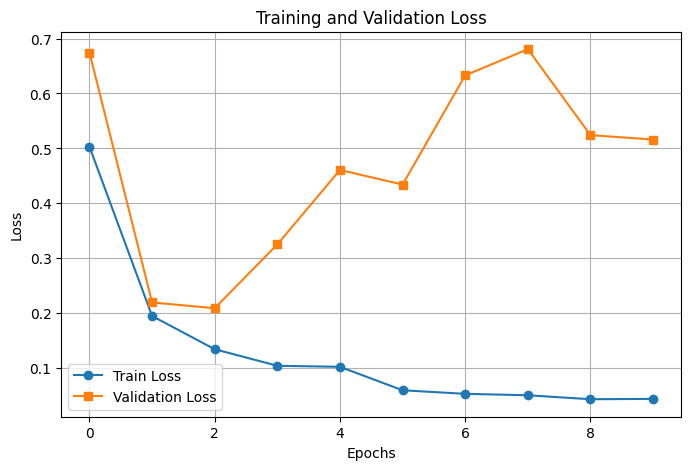

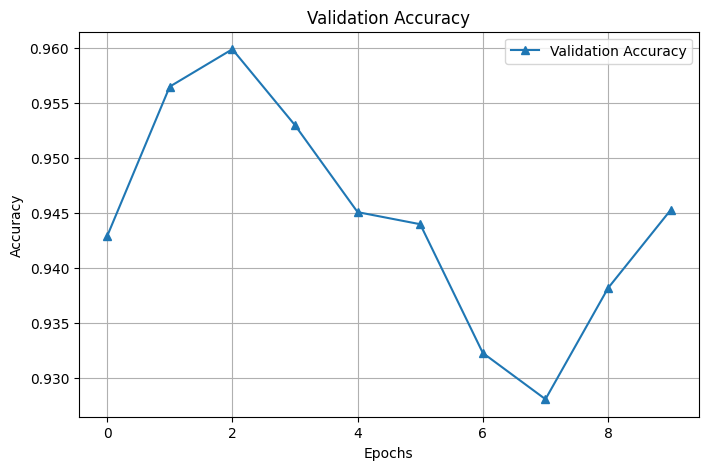

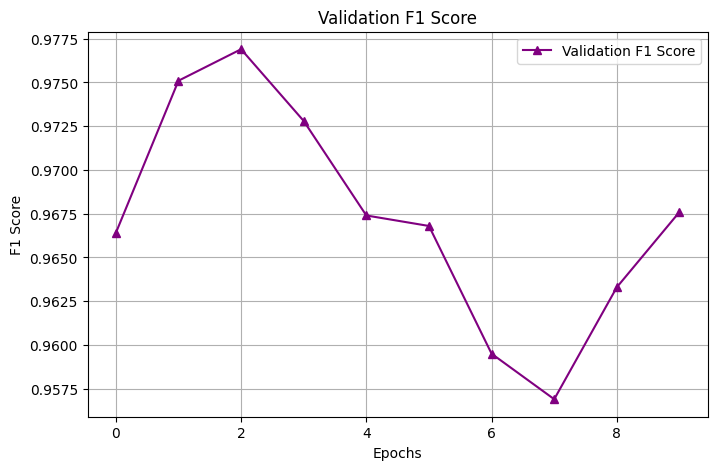

In [ ]:
# Plot training metrics
plot_training_metrics(train_losses, val_losses, val_accuracies, val_f1_scores)

**Save and load the model**

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CV_Final_Project/cnn_lstm.pth")

In [ ]:
# Load the model for inference
model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/cnn_lstm.pth"))
model.eval()

<ipython-input-27-783dcf776600>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/drowsiness_cnn_ls

CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=25088, out_features=256, bias=True)
  (lstm): LSTM(256, 128, batch_first=True)
  (classifier): Lin

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 0.8266

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.46      0.82      0.59       601
  non-drowsy       0.96      0.83      0.89      3408

    accuracy                           0.83      4009
   macro avg       0.71      0.82      0.74      4009
weighted avg       0.89      0.83      0.84      4009



**Predict New Images**

In [ ]:
def predict_image(image_path, model, transform, class_names, device):
    """
    Predict the class of a given image using the model.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        transform (callable): Transformations to apply to the image.
        class_names (list): List of class names.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        str: Predicted class label.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension (1, C, H, W)

    # Simulate a sequence with sequence_length=1
    sequence_tensor = image_tensor.unsqueeze(0)  # Shape: (1, sequence_length=1, C, H, W)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(sequence_tensor).squeeze(0)  # Remove batch dimension
        probability = torch.sigmoid(output).item()  # Apply sigmoid to get probability
        predicted_class_idx = int(probability > 0.5)  # Threshold at 0.5

    return class_names[predicted_class_idx]

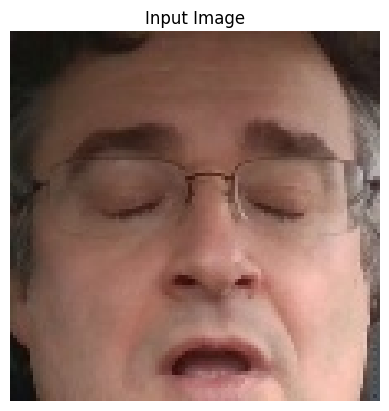

Prediction: drowsy


In [ ]:
# Ensure the model and input are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict on a new image
test_image_path = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames/train/drowsy/gA_1_s5_2019-03-14T14;26;17+01;00_rgb_face_frame_01374.jpg"
prediction = predict_image(test_image_path, model, transform, class_names, device)
print(f"Prediction: {prediction}")

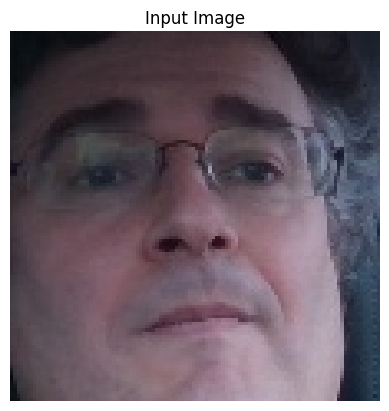

Prediction: non-drowsy


In [ ]:
# Predict on a new image
test_image_path = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames/train/non-drowsy/gA_1_s5_2019-03-14T14;26;17+01;00_rgb_face_frame_00009.jpg"
prediction = predict_image(test_image_path, model, transform, class_names, device)
print(f"Prediction: {prediction}")

**Train the model - Second Trial**

In [ ]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Paths to train, validation, and test directories
data_base_dir = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames"
train_dir = os.path.join(data_base_dir, "train")
val_dir = os.path.join(data_base_dir, "val")
test_dir = os.path.join(data_base_dir, "test")

# Instantiate datasets
train_dataset = VideoFrameDataset(train_dir, transform=transform, sequence_length=10)
val_dataset = VideoFrameDataset(val_dir, transform=transform, sequence_length=10)
test_dataset = VideoFrameDataset(test_dir, transform=transform, sequence_length=10)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Class names
class_names = train_dataset.classes  # Use the `classes` attribute from the dataset
print(f"Classes: {class_names}")
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Compute class counts
train_class_counts = train_dataset.get_class_counts()
drowsy_count = train_class_counts[train_dataset.class_to_idx['drowsy']]
non_drowsy_count = train_class_counts[train_dataset.class_to_idx['non-drowsy']]

# Compute class weights
class_weights = non_drowsy_count / drowsy_count
print("Class weights:", class_weights)

Classes: ['drowsy', 'non-drowsy']
Train size: 10913, Validation size: 3768, Test size: 4009
Class weights: 4.519979767324228


In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNNLSTM().to(device)

# Initialize loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights).to(device))

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

Using device: cuda


In [ ]:
def train_model2(model, train_loader, val_loader, num_epochs=10, patience=3):
    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device).float()
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Collect predictions and labels for F1 score
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_f1 = f1_score(all_labels, all_preds, average="binary")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Save best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # Save best weights
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        # Update learning rate
        scheduler.step()

    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)

    return train_losses, val_losses, val_accuracies, val_f1_scores


In [ ]:
train_losses, val_losses, val_accuracies, val_f1_scores = train_model2(
    model, train_loader, val_loader, num_epochs=10
)

Epoch 1/10, Train Loss: 0.6742, Val Loss: 0.3778, Val Accuracy: 0.8941, Val F1: 0.9416
Epoch 2/10, Train Loss: 0.2530, Val Loss: 0.2463, Val Accuracy: 0.9260, Val F1: 0.9584
Epoch 3/10, Train Loss: 0.1557, Val Loss: 0.4064, Val Accuracy: 0.9427, Val F1: 0.9664
Epoch 4/10, Train Loss: 0.1198, Val Loss: 0.1796, Val Accuracy: 0.9522, Val F1: 0.9728
Epoch 5/10, Train Loss: 0.1049, Val Loss: 0.1570, Val Accuracy: 0.9575, Val F1: 0.9757
Epoch 6/10, Train Loss: 0.0984, Val Loss: 0.3113, Val Accuracy: 0.9647, Val F1: 0.9794
Epoch 7/10, Train Loss: 0.0804, Val Loss: 1.5514, Val Accuracy: 0.8240, Val F1: 0.8857
Epoch 8/10, Train Loss: 0.0992, Val Loss: 0.2779, Val Accuracy: 0.9684, Val F1: 0.9815
Early stopping triggered.


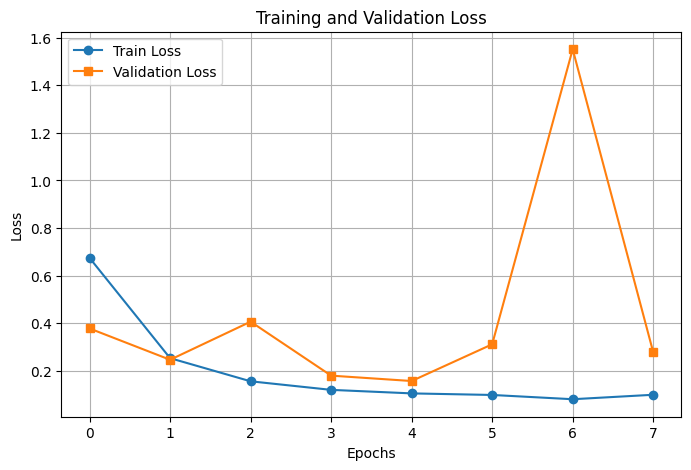

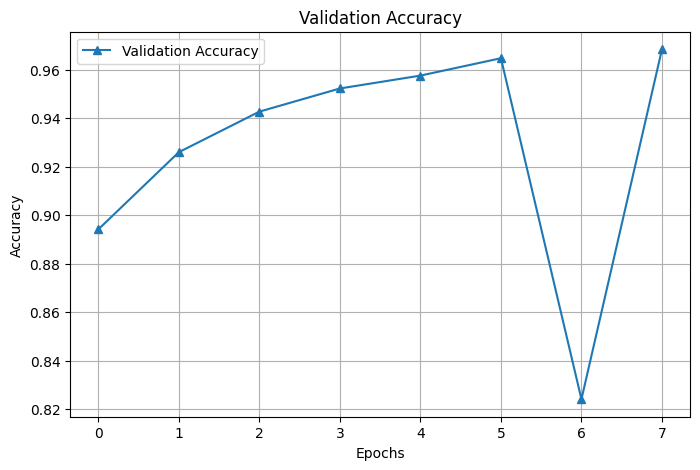

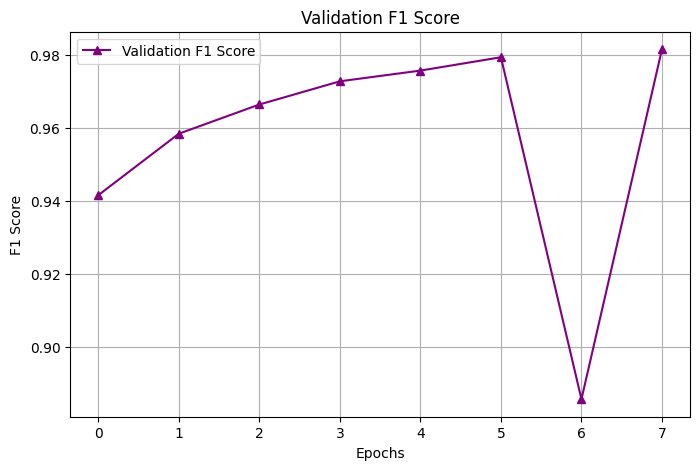

In [ ]:
# Plot training metrics
plot_training_metrics(train_losses, val_losses, val_accuracies, val_f1_scores)

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CV_Final_Project/cnn_lstm2.pth")

In [ ]:
# Load the model for inference
model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/cnn_lstm2.pth"))
model.eval()

<ipython-input-18-6c75c0866327>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/drowsiness_cnn_ls

CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=25088, out_features=256, bias=True)
  (lstm): LSTM(256, 128, batch_first=True)
  (classifier): Lin

In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 0.9157

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.68      0.82      0.74       601
  non-drowsy       0.97      0.93      0.95      3408

    accuracy                           0.92      4009
   macro avg       0.82      0.87      0.85      4009
weighted avg       0.92      0.92      0.92      4009

